# imports..

In [1]:
vault = 'DynYieldE'

In [2]:
import os, sys, json
cwd = os.getcwd()
PROJECT_PATH = cwd[:cwd.find('midfreq')+7]
print('PROJECT_PATH:', PROJECT_PATH)
if PROJECT_PATH not in sys.path: sys.path.append(PROJECT_PATH)
os.chdir(PROJECT_PATH) 

import json
import yaml
import numpy as np
import pandas as pd
from copy import deepcopy
import warnings
warnings.filterwarnings(action='once')

PROJECT_PATH: /home/user/singularity/midfreq


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# load data

In [4]:
metadata = pd.read_csv(f"{PROJECT_PATH}/data/{vault}_pool_metadata.csv")
with open(f"{PROJECT_PATH}/config/{vault.lower()}.yaml") as file:
    parameters= yaml.safe_load(file)
selected_instruments = parameters['input_data']['selected_instruments']
if selected_instruments == 'all':
    pool_map = metadata.set_index('pool').T.to_dict()
else:
    pool_map = metadata.loc[metadata['pool'].isin(selected_instruments)].set_index('pool').T.to_dict()
pool_map = {key2: '_'.join([str(x[key]) for key in ['chain', 'project', 'symbol', 'poolMeta'] if x[key] is not np.nan]) for key2, x in pool_map.items()}
index_map = {f'weight_{i}': f'w_{value}' for i, value in enumerate(pool_map.values())}
index_map |= {f'yield_{i}': f'y_{value}' for i, value in enumerate(pool_map.values())} 
with open(f"{PROJECT_PATH}/config/{vault.lower()}.yaml", 'r') as fp:
    parameters = yaml.safe_load(fp)

### naive optimization - no swap_cost

In [54]:
parameter_grid = {'strategy.initial_wealth': [1e5, 1e6, 2.5e6, 5e6, 1e7],
                            'run_parameters.models.apy.TrivialEwmPredictor.params.cap': [3],
                          'run_parameters.models.apy.TrivialEwmPredictor.params.halflife': ["10d"],
                          'strategy.cost': [0.0005],
                          'strategy.gas': [False, 20, 50],
                         'strategy.base_buffer': [0.1],
                         "run_parameters.models.apy.TrivialEwmPredictor.params.horizon": ["99y"],
                          "label_map.apy.horizons": [[28]],
                          "strategy.concentration_limit": [0.4]}
filename = "{}/logs/{}/{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(PROJECT_PATH, vault.lower(), *parameter_grid.values())
backtest = pd.read_csv(filename, header=[0,1])

FileNotFoundError: [Errno 2] No such file or directory: "/home/user/singularity/midfreq/logs/dynyielde/[100000.0, 1000000.0, 2500000.0, 5000000.0, 10000000.0]_[3]_['10d']_[0.0005]_[False, 20, 50]_[0.1]_['99y']__backtest.csv"

In [ ]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

apy.mean()

### naive optimization - 10bps swap_cost

In [ ]:
parameter_grid = {"cap": 3,
                  "halflife": "1s",
                  "cost": 0.001,
                  "gaz": False,
                  "assumed_holding_days": 9999,
                  "base_buffer": 0.15,
                  "concentration_limit": 1.0}
filename = "{}/logs/{}/{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(PROJECT_PATH, vault.lower(), *parameter_grid.values())
backtest = pd.read_csv(filename, header=[0,1])

In [ ]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

print(filename)
apy.mean()

### cost aware optimization (28d holding)

In [ ]:
parameter_grid = {"cap": 3,
                  "halflife": "1s",
                  "cost": 0.001,
                  "gaz": False,
                  "assumed_holding_days": 28,
                  "base_buffer": 0.15,
                  "concentration_limit": 1.0}
filename = "{}/logs/{}/{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(PROJECT_PATH, vault.lower(), *parameter_grid.values())
backtest = pd.read_csv(filename, header=[0,1])

In [ ]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

print(filename)
apy.mean()

# cost aware smoothed (10d) optimization (28d holding)

In [5]:
parameter_grid = {'strategy.initial_wealth': 1e6,
                            'run_parameters.models.apy.TrivialEwmPredictor.params.cap': 3,
                          'run_parameters.models.apy.TrivialEwmPredictor.params.halflife': "10d",
                          'strategy.cost': 0.0005,
                          'strategy.gas': 50,
                         'strategy.base_buffer': 0.1,
                         "run_parameters.models.apy.TrivialEwmPredictor.params.horizon": "99y",
                          "label_map.apy.horizons": [28],
                          "strategy.concentration_limit": 0.4}
filename = "{}/logs/{}/{}_{}_{}_{}_{}_{}_{}_{}_{}__backtest.csv".format(PROJECT_PATH, vault.lower(), *parameter_grid.values())
#filename = "{}/logs/{}/_backtest.csv".format(PROJECT_PATH, vault.lower())
backtest = pd.read_csv(filename, header=[0,1], index_col=0)

In [6]:
backtest['pnl']["tx_cost"].iloc[0] = 0.001
cum_tx_cost = backtest['pnl']["tx_cost"].cumsum()
apy = (backtest['pnl']['wealth'] / backtest['pnl']['wealth'].shift(1) -1)*365/1*100
max_apy = backtest['full_apy'].max(axis=1)*100*(1-parameter_grid["strategy.base_buffer"])
max_apy.name = 'max_apy'

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures with px.line each containing data from multiple columns
fig = px.line(apy,render_mode="webgl",)
fig3 = px.line(max_apy, render_mode="webgl")
fig3.update_traces(line={"dash": 'dot'})
fig2 = px.line(cum_tx_cost, render_mode="webgl",)
fig2.update_traces(yaxis="y2")
subfig.add_traces(fig.data + fig2.data + fig3.data)
subfig.layout.xaxis.title = "time"
subfig.layout.yaxis.title = "apy"
subfig.layout.yaxis.range = [0, 15]
subfig.layout.yaxis2.title = "tx_cost"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

print(filename)
apy.mean(), max_apy.mean()

/home/user/singularity/midfreq/logs/dynyielde/1000000.0_3_10d_0.0005_50_0.1_99y_[28]_0.4__backtest.csv


(10.273145100062875, 41.67756978688524)

## zoom on optimal settings

In [10]:
weights = backtest['weights']
weights.iplot(title='weights')

In [8]:
apy = backtest['apy']
apy.iplot(title='apy')

In [67]:
tracking_error = (backtest['pred_apy'].rolling(28).mean().shift(-28)-backtest['apy'])
tracking_error.iplot(title='tracking_error')

/home/user/singularity/midfreq/venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



# heatmaps

In [98]:
parameter_grid = {'strategy.initial_wealth': [1e5, 1e6, 2.5e6, 5e6, 1e7],
                            'run_parameters.models.apy.TrivialEwmPredictor.params.cap': [3],
                          'run_parameters.models.apy.TrivialEwmPredictor.params.halflife': ["10d"],
                          'strategy.cost': [0.0005],
                          'strategy.gas': [False, 20, 50],
                         'strategy.base_buffer': [0.1],
                         "run_parameters.models.apy.TrivialEwmPredictor.params.horizon": ["99y"],
                          "label_map.apy.horizons": [[28]],
                          "strategy.concentration_limit": [0.4]}

In [99]:
pd.read_csv(f"{PROJECT_PATH}/logs/{vault.lower()}/grid.csv", index_col=0)

/home/user/singularity/midfreq/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:518: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



strategy.initial_wealth  \
0                  100000.0   
1                  100000.0   
2                  100000.0   
3                 1000000.0   
4                 1000000.0   
5                 1000000.0   
6                 2500000.0   
7                 2500000.0   
8                 2500000.0   
9                 5000000.0   
10                5000000.0   
11                5000000.0   
12               10000000.0   
13               10000000.0   
14               10000000.0   

    run_parameters.models.apy.TrivialEwmPredictor.params.cap  \
0                                                   3          
1                                                   3          
2                                                   3          
3                                                   3          
4                                                   3          
5                                                   3          
6                                                   3          
7                                                   3          
8                                                   3          
9                                                   3          
10                                                  3          
11                                                  3          
12                                                  3          
13                                                  3          
14                                                  3          

   run_parameters.models.apy.TrivialEwmPredictor.params.halflife  \
0                                                 10d              
1                                                 10d              
2                                                 10d              
3                                                 10d              
4                                                 10d              
5                                                 10d              
6                                                 10d              
7                                                 10d              
8                                                 10d              
9                                                 10d              
10                                                10d              
11                                                10d              
12                                                10d              
13                                                10d              
14                                                10d              

    strategy.cost strategy.gas  strategy.base_buffer  \
0          0.0005        False                   0.1   
1          0.0005           20                   0.1   
2          0.0005           50                   0.1   
3          0.0005        False                   0.1   
4          0.0005           20                   0.1   
5          0.0005           50                   0.1   
6          0.0005        False                   0.1   
7          0.0005           20                   0.1   
8          0.0005           50                   0.1   
9          0.0005        False                   0.1   
10         0.0005           20                   0.1   
11         0.0005           50                   0.1   
12         0.0005        False                   0.1   
13         0.0005           20                   0.1   
14         0.0005           50                   0.1   

   run_parameters.models.apy.TrivialEwmPredictor.params.horizon  \
0                                                 99y             
1                                                 99y             
2                                                 99y             
3                                                 99y             
4                                                 99y             
5                                                 99y             
6                          

In [100]:
grid = pd.read_csv(f"{PROJECT_PATH}/logs/{vault.lower()}/grid.csv", index_col=0)
grid['tx_cost'].iloc[0] = 0.001
all_index = {col: grid[col].unique() for col in grid.columns}
print(grid.columns)

grid['churn in d'] = grid.apply(lambda x: 2 * 365 * x['strategy.cost']/x['tx_cost']/100, axis=1)

format_dict = {key: (lambda x: x) for key in grid.columns}
format_dict['perf'] = lambda x: f'{x:.1%}'
format_dict['tx_cost'] = lambda x : f'{x:.0f}'
format_dict['avg_entropy'] = lambda x: f'{x:.0%}'

def display_heatmap(metrics, ind, col, filtering):
    fig = plt.figure(figsize = (20,20)) # width x height
    
    # filter
    filtered_grid = grid[np.logical_and.reduce([
            grid[filter_c]==filter_v
        for filter_c, filter_v in filtering.items()])]
    
    # pivot and display
    for i, values in enumerate(metrics):
        for j, column in enumerate(col):
            df = filtered_grid.pivot_table(values=values, index=ind, columns=col)*100
            ax = fig.add_subplot(len(col), len(metrics), i+j+1)
            ax.set_title(f'{values} by {column}')
            sns.heatmap(data=df, ax=ax, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
            
grid    

Index(['strategy.initial_wealth',
       'run_parameters.models.apy.TrivialEwmPredictor.params.cap',
       'run_parameters.models.apy.TrivialEwmPredictor.params.halflife',
       'strategy.cost', 'strategy.gas', 'strategy.base_buffer',
       'run_parameters.models.apy.TrivialEwmPredictor.params.horizon',
       'label_map.apy.horizons', 'strategy.concentration_limit', 'perf',
       'tx_cost', 'avg_entropy'],
      dtype='object')


/home/user/singularity/midfreq/venv/lib/python3.10/site-packages/pandas/core/algorithms.py:518: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/home/user/singularity/midfreq/venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



strategy.initial_wealth  \
0                  100000.0   
1                  100000.0   
2                  100000.0   
3                 1000000.0   
4                 1000000.0   
5                 1000000.0   
6                 2500000.0   
7                 2500000.0   
8                 2500000.0   
9                 5000000.0   
10                5000000.0   
11                5000000.0   
12               10000000.0   
13               10000000.0   
14               10000000.0   

    run_parameters.models.apy.TrivialEwmPredictor.params.cap  \
0                                                   3          
1                                                   3          
2                                                   3          
3                                                   3          
4                                                   3          
5                                                   3          
6                                                   3          
7                                                   3          
8                                                   3          
9                                                   3          
10                                                  3          
11                                                  3          
12                                                  3          
13                                                  3          
14                                                  3          

   run_parameters.models.apy.TrivialEwmPredictor.params.halflife  \
0                                                 10d              
1                                                 10d              
2                                                 10d              
3                                                 10d              
4                                                 10d              
5                                                 10d              
6                                                 10d              
7                                                 10d              
8                                                 10d              
9                                                 10d              
10                                                10d              
11                                                10d              
12                                                10d              
13                                                10d              
14                                                10d              

    strategy.cost strategy.gas  strategy.base_buffer  \
0          0.0005        False                   0.1   
1          0.0005           20                   0.1   
2          0.0005           50                   0.1   
3          0.0005        False                   0.1   
4          0.0005           20                   0.1   
5          0.0005           50                   0.1   
6          0.0005        False                   0.1   
7          0.0005           20                   0.1   
8          0.0005           50                   0.1   
9          0.0005        False                   0.1   
10         0.0005           20                   0.1   
11         0.0005           50                   0.1   
12         0.0005        False                   0.1   
13         0.0005           20                   0.1   
14         0.0005           50                   0.1   

   run_parameters.models.apy.TrivialEwmPredictor.params.horizon  \
0                                                 99y             
1                                                 99y             
2                                                 99y             
3                                                 99y             
4                                                 99y             
5                                                 99y             
6                          

## churn vs     activeness / predictor halflife -> halflife = 10d horizon = ~4w

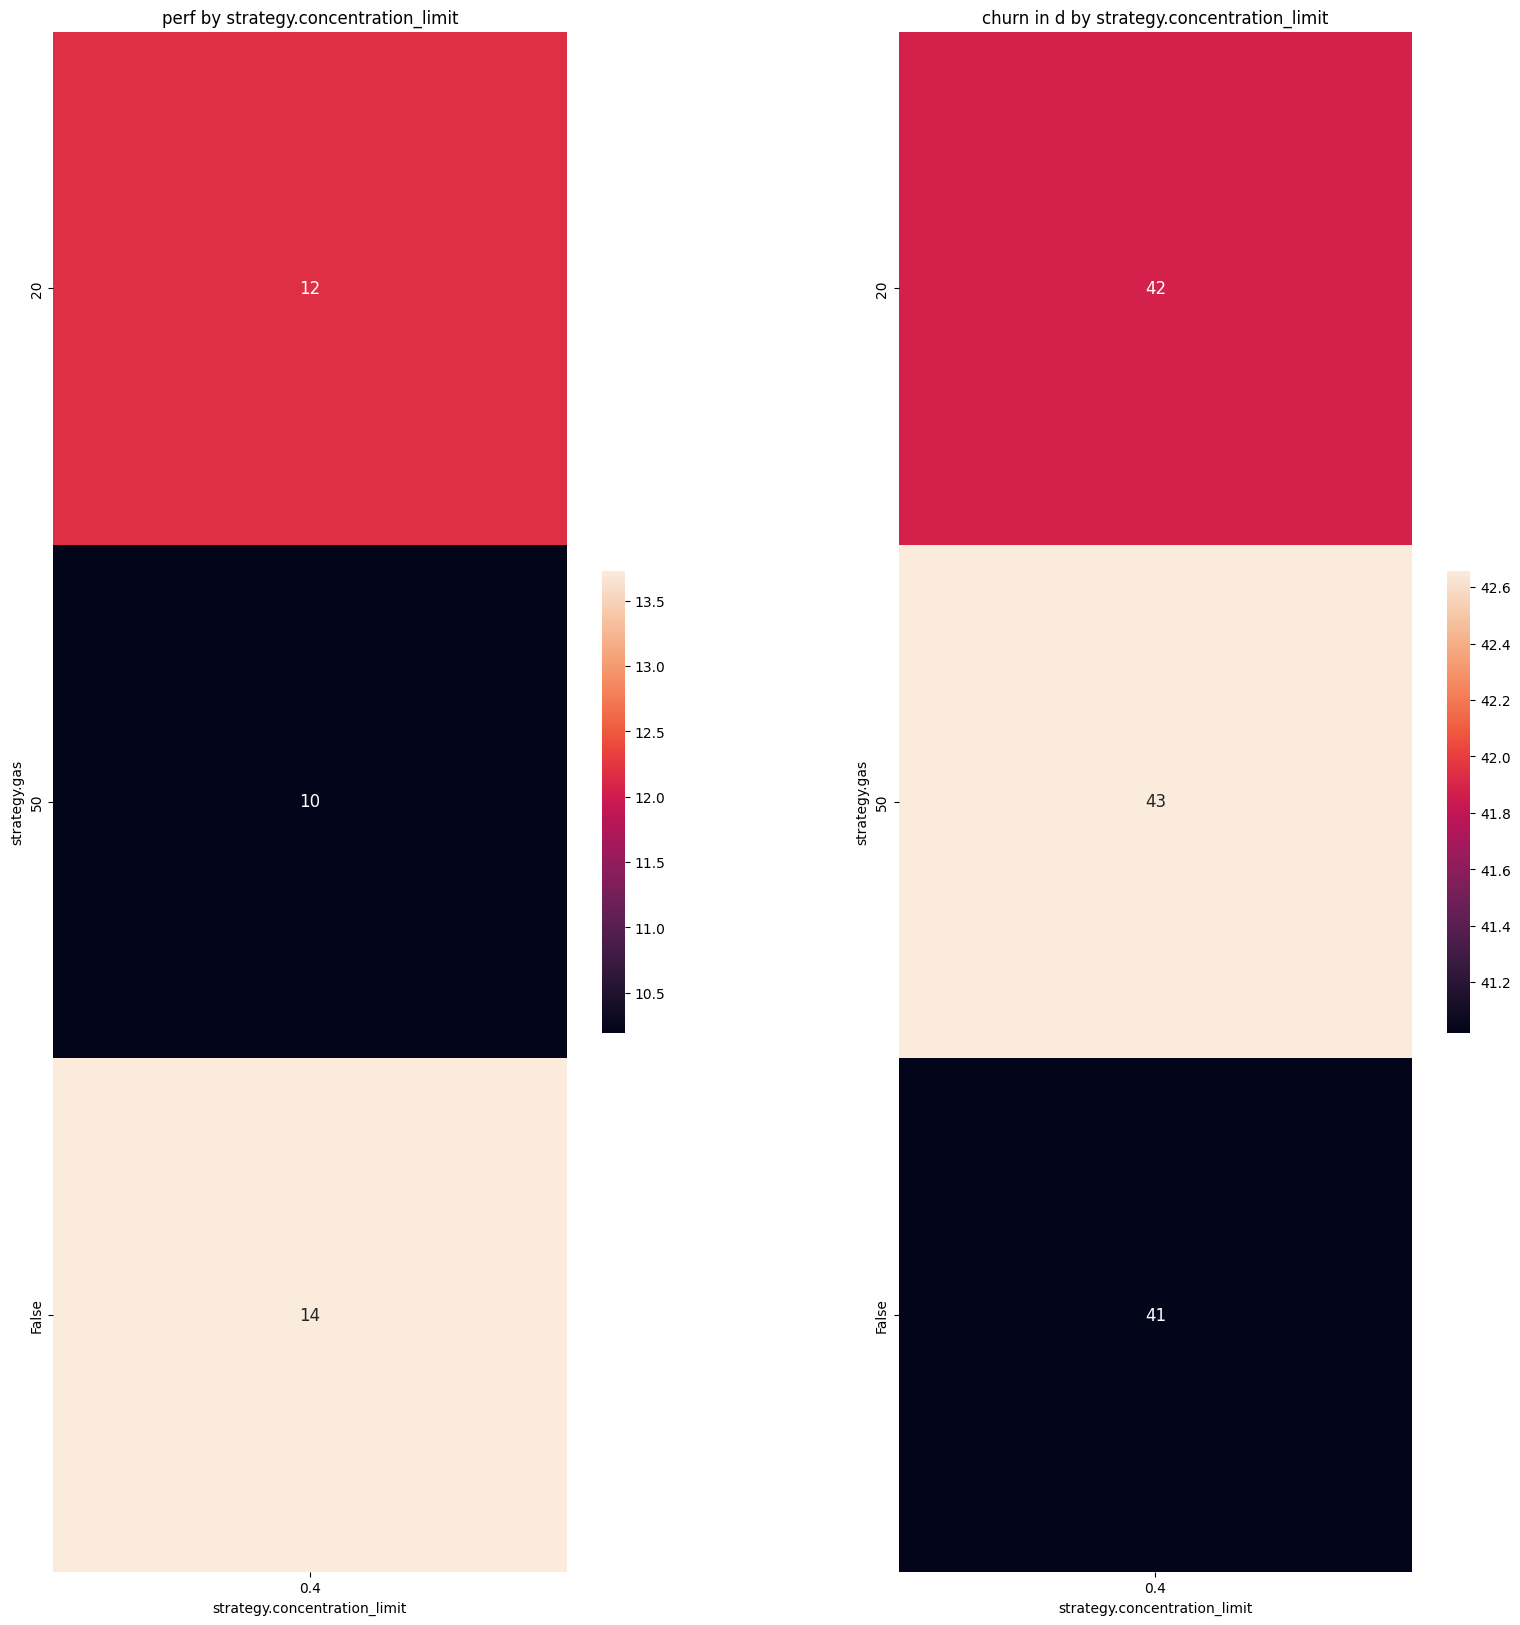

In [101]:
metrics = ['perf', 'churn in d']
ind = ['strategy.gas']
col = ['strategy.concentration_limit']
filtering = {'strategy.initial_wealth': 1e6,
                            'run_parameters.models.apy.TrivialEwmPredictor.params.cap': 3,
                          'run_parameters.models.apy.TrivialEwmPredictor.params.halflife': "10d",
                          'strategy.cost': 0.0005,
                          #'strategy.gas': [False, 20, 50],
                         'strategy.base_buffer': 0.1,
                         "run_parameters.models.apy.TrivialEwmPredictor.params.horizon": "99y",
                          #"label_map.apy.horizons": [28],
                          #"strategy.concentration_limit": [0.4]
            }
display_heatmap(metrics, ind, col, filtering)

## entropy vs     concentration x activeness

ValueError: zero-size array to reduction operation fmin which has no identity

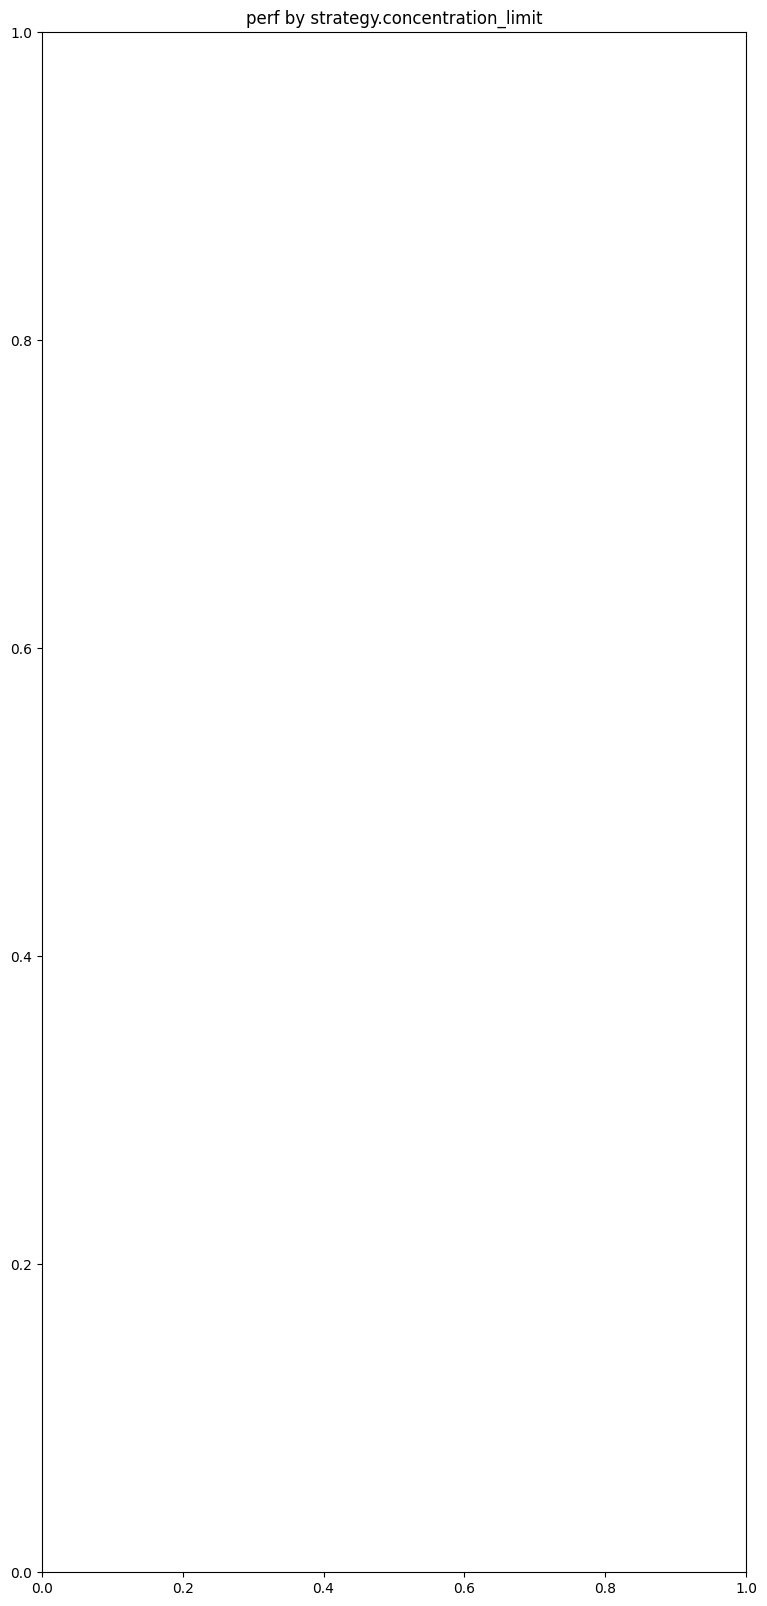

In [103]:
filtering = {'strategy.initial_wealth': 1e6,
                           # 'run_parameters.models.apy.TrivialEwmPredictor.params.cap': 3,
                          'run_parameters.models.apy.TrivialEwmPredictor.params.halflife': "10d",
                          'strategy.cost': 0.0005,
                          'strategy.gas': 50,
                         'strategy.base_buffer': 0.1,
                         "run_parameters.models.apy.TrivialEwmPredictor.params.horizon": "99y",
                          "label_map.apy.horizons": [28],
                          #"strategy.concentration_limit": 0.4
            }
metrics = ['perf', 'avg_entropy']
ind = ['run_parameters.models.apy.TrivialEwmPredictor.params.cap']
col = ['strategy.concentration_limit']
display_heatmap(metrics, ind, col, filtering)

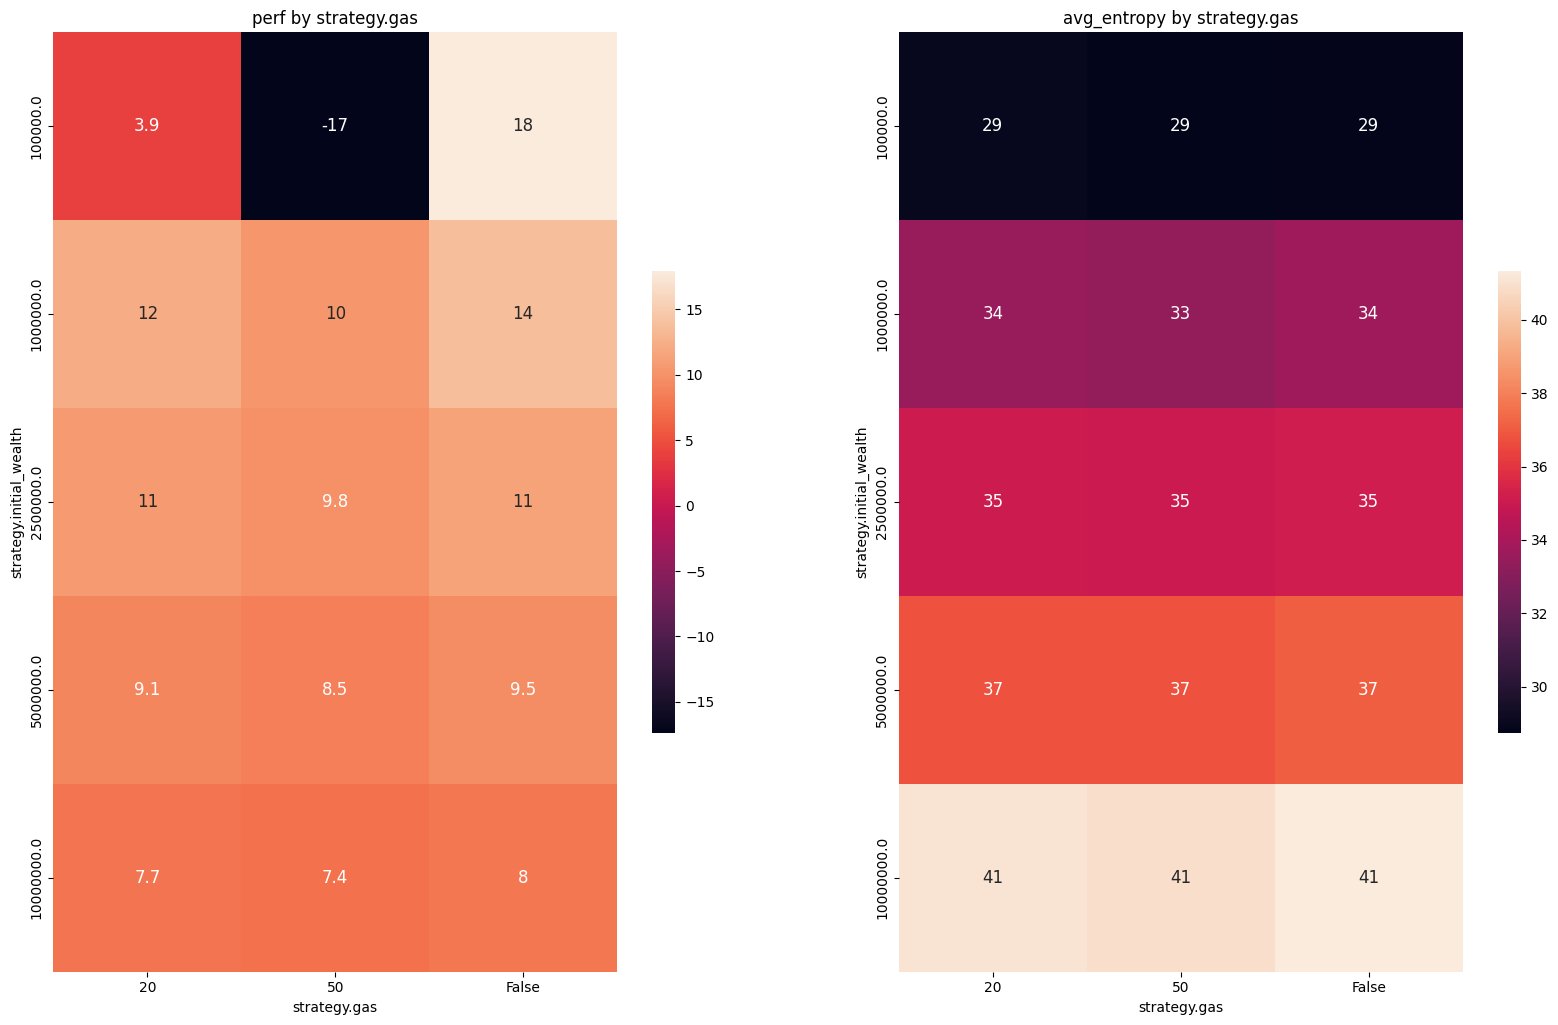

In [106]:
filtering = {#'strategy.initial_wealth': 1e6,
                           'run_parameters.models.apy.TrivialEwmPredictor.params.cap': 3,
                          'run_parameters.models.apy.TrivialEwmPredictor.params.halflife': "10d",
                          'strategy.cost': 0.0005,
               #           'strategy.gas': [False, 20, 50],
                         'strategy.base_buffer': 0.1,
                         "run_parameters.models.apy.TrivialEwmPredictor.params.horizon": "99y",
                          #"label_map.apy.horizons": [28],
                          "strategy.concentration_limit": 0.4
            }
metrics = ['perf', 'avg_entropy']
ind = ['strategy.initial_wealth']
col = ['strategy.gas']
display_heatmap(metrics, ind, col, filtering)